## egg2oq

Assume we have a stereo audio file, where the acoustic waveform is in the left channel, and an electroglottograph (EGG) signal is in the right channel (Herbst, 2020).

This notebook, written by Keith Johnson and adapted by Amber Galvano, illustrates some processing steps to calculate the vocal fold vibration open quotient (OQ) from the EGG signal.


Christian T. Herbst (2020) "Electroglottography − An Update." *Journal of Voice*, **34**(4), pp. 503-526.

In [36]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from pathlib import Path
from phonlab.utils import dir2df

### make_frames()

Declaring here a small function that takes a waveform and returns a 2D array of frames of data

For example, a six sample waveform split into frames of three samples each, with a step/hop of
one sample between each frame gives this:

    [1,2,3,4,5,6] --> [[1,2,3],
                         [2,3,4],
                         [3,4,5],
                         [4,5,6]]
                         
In this example the first frame is [1,2,3].

In [37]:
def make_frames(array, winsize,stride):
    '''
    make_frames(array,winsize,stride)

    takes a 1D array (one channel of audio data for example), and returns a 2D
    array of frames. each frame is 'winsize' long, and the starting points of
    the frames are at intervals of 'stride'.  'winsize' and 'stride' must be given
    in number of samples.  Here is an example call (where fs is the sampling rate):

    frames = make_frames(signal,int(0.015*fs),int(0.005*fs))  # 15ms windows, 5ms hop

    '''
    if array.ndim > 1:
        print('make_frames() wants a 1D array')
        return None

    max_time = array.size-(winsize+1)

    sub_windows = (
        np.expand_dims(np.arange(winsize), 0) +
        np.expand_dims(np.arange(max_time + 1, step=stride), 0).T
    )
    return array[sub_windows]

## 1. Get Data

We have an random EGG file for illustration.

Librosa.load is used to open and downsample the stereo file.
The channels are separated into separate arrays.

In [38]:
# check your file exists in the specified path
import os

file_path = ('/Users/ambergalvano/Library/CloudStorage/GoogleDrive-amber_galvano@berkeley.edu/My Drive/research_projects/Lobi/Galvano_Lobi_phonetics/data/EGG+vowels_pt2/full_recordings/Sansan/SH_20230323_EGG1/lob_san_20230323_acg_EGG_SIGNAL_1.wav')

if os.path.exists(file_path):
    print("File exists!")
else:
    print("File not found. Check the path.")

File exists!


In [39]:
target_fs = 16000

# to do: save file name as variable and use it to populate new col in Oq_data
data, fs = librosa.load("lob_san_20230323_acg_EGG_SIGNAL_1.wav", sr=target_fs, mono=False,)
print(f'sampling rate: {fs}, Number of samples {data.shape[1]}, and channels: {data.shape[0]}')

audio = data[0]
egg_x = data[1]

sampling rate: 16000, Number of samples 15352459, and channels: 2


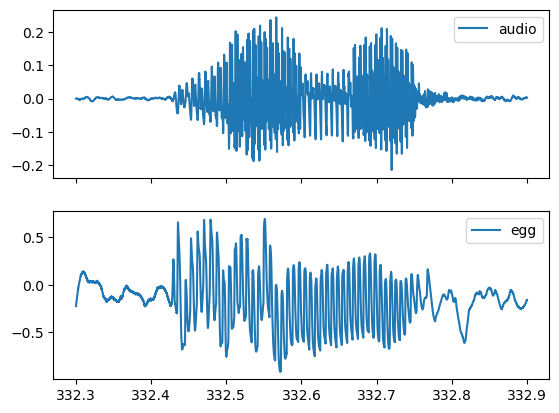

In [40]:
# plot a sample of the waveforms
time = [i/fs for i in range(audio.size)]   ## the time values associated with the waveforms, for plotting.

start = int(332.3*fs)
end = int(332.9*fs)

fig = plt.figure()
ax1 =fig.add_subplot(211,)
ax1.plot(time[start:end],audio[start:end],label="audio")
ax1.set_xticklabels([])
ax1.legend()
ax2 =fig.add_subplot(212)
ax2.plot(time[start:end],egg_x[start:end],label="egg")
ax2.legend()

## 2. Highpass filter the EGG signal

This script uses a pretty high frequency cutoff, and a pretty steep filter.
The forward/backward filtering provided by the scipy.signal.\*filtfilt does not impact the phase and thus preserves the EGG waveshape.  See Rothenburg (2002) on this filtering choice.

Rothenberg, Martin (2002) Correcting low-frequency phase distortion in electroglottograph waveforms. *Journal of Voice*, **16**(1), 32-36.

In [41]:
# highpass filter the egg signal
cutoff_freq = 70
filter_order = 8
coefs = sp.signal.butter(filter_order, cutoff_freq, fs=fs, btype='highpass', output='sos')
egg = sp.signal.sosfiltfilt(coefs, egg_x)

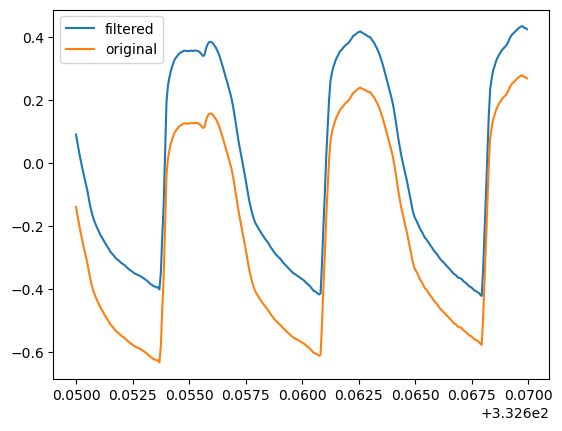

In [42]:
# the filtering must preserve the waveform shape

start = int(332.65*fs)
end = int(332.67*fs)

plt.plot(time[start:end],egg[start:end],label="filtered")
plt.plot(time[start:end],egg_x[start:end],label="original")
plt.legend()

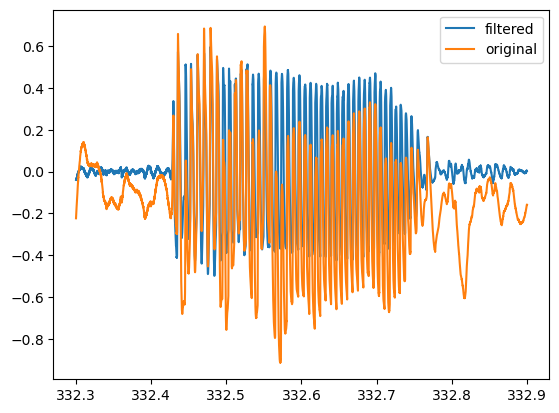

In [43]:
# and remove large/slow fluctuations

start = int(332.3*fs)
end = int(332.9*fs)

plt.plot(time[start:end],egg[start:end],label="filtered")
plt.plot(time[start:end],egg_x[start:end],label="original")

plt.legend()

## 3. Find glottal closing and opening events

Using normalized EGG and dEGG signals, we here find glottal closing and opening events using the 'hybrid' method, that is reviewed in Herbst (2020).

scipy.signal.find_peaks() is applied to the degg signal, to find glottal closure instances (GCI), and a threshold of 0.43 in the normalized EGG is used to find glottal opening instances (GOI).

An additional signal using the 'thresholding' method is created but not used.

In [44]:
degg = np.gradient(egg)

# scale the filtered egg and degg to (0,1)
egg = (egg - np.min(egg))/(np.max(egg)-np.min(egg))
degg = (degg - np.min(degg))/(np.max(degg)-np.min(degg))

# ** thresholding method of calculating closed quotient could use this signal (not used)
closed = egg > 0.43

# ** hybrid method of OQ calculation
# get peaks in the degg waveform - the glottal closing instants (gci)
# minimum spacing between peaks (distance) is 5.5 ms
degg_peaks = sp.signal.find_peaks(degg,distance=0.0055*fs)
glottal = np.zeros(degg.size)
glottal[degg_peaks[0]]=1  # closing times (peaks returns indices of peaks)
for i in range(egg.size-1):  # opening times (threshold method)
    if egg[i]>0.43 and egg[i+1]<0.43:
        glottal[i] = -1

In [45]:
#open_time

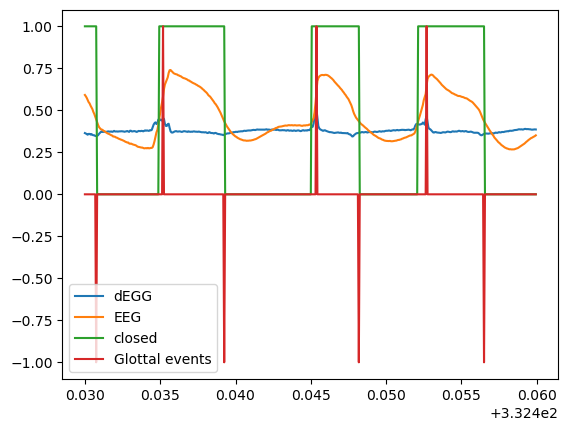

In [46]:
start = int(332.43*fs)
end = int(332.46*fs)

plt.plot(time[start:end],degg[start:end],label="dEGG")
plt.plot(time[start:end],egg[start:end],label="EEG")
plt.plot(time[start:end],closed[start:end],label="closed")
plt.plot(time[start:end],glottal[start:end],label="Glottal events")
plt.legend()

## 4. Calculate OQ from the glottal events waveform

- The glottal events waveform is split into frames, and find indices of GCI and GOI in each frame.

- If there are no glottal events we will leave 0 as the measure of OQ (and F0).

- Take the duration of the first pitch period in the frame.  Find a GOI that occurs in the first pitch period in the frame.

- Save the open quotient and F0 for the frame, derived from these measures.

In [47]:
window_length = 0.02
hop_dur = 0.005
frame_rate = 1/hop_dur

win = int(window_length*fs)  # 15ms windows,
hop = int(hop_dur*fs)  # 5ms hop


frames = make_frames(glottal,win,hop)   # split the glottal events waveform into frames
ftime = [i/frame_rate for i in range(frames.shape[0])]  # get times of frames, for plotting

print(f'{frames.shape[0]} frames will be processed')

f0 = np.zeros(frames.shape[0])
OQ = np.zeros(frames.shape[0])

OQ_data = pd.DataFrame()
OQ_value = []
f0_value = []
glottal_k = []
time = []

for k in range(frames.shape[0]):

    gci = np.argwhere(frames[k] == 1.0)  # glottal closures in the frame
    goi = np.argwhere(frames[k] == -1.0)  # glottal openings
    if (gci.size<2):  # nothing to look at
        continue
    if (goi.size<2):  # nothing to look at
        continue

    period = gci[1]-gci[0]  # interval between closures
    f0[k] = 1/(period/fs)
    if goi[0] > gci[0] and goi[0]<gci[1]:  # find an appropriate opening instant
        op = goi[0]
    elif goi[1] > gci[0] and goi[1]<gci[1]:
        op = goi[1]
    else:
        continue

    OQ[k] = (gci[1]-op)/period

    OQ_value.append(OQ[k])
    time.append(ftime[k])
    glottal_k.append(glottal[k])

191902 frames will be processed


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/1687389729.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f0[k] = 1/(period/fs)
/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/1687389729.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OQ[k] = (gci[1]-op)/period


In [48]:
OQ_value = [str(x) for x in OQ_value]
time = [str(x) for x in time]
glottal_k = [str(x) for x in glottal_k]

In [49]:
OQ_data["OQ_value"] = pd.DataFrame(OQ_value)
OQ_data["OQ_time"] = pd.DataFrame(time)
OQ_data["glottal_o"] = pd.DataFrame(glottal_k)
OQ_data.head()

,OQ_value,OQ_time,glottal_o
0,0.3867924528301887,0.45,0.0
1,0.018691588785046728,0.455,0.0
2,0.8804347826086957,0.46,0.0
3,0.8804347826086957,0.465,0.0
4,0.2037037037037037,0.475,0.0


In [50]:
OQ_data = OQ_data[OQ_data['glottal_o'] == '1.0']
OQ_data.head()

,OQ_value,OQ_time,glottal_o
17,0.2088607594936709,0.965,1.0
77,0.34065934065934067,2.845,1.0
172,0.5953757225433526,5.925,1.0
218,0.17073170731707318,8.63,1.0
291,0.6120689655172413,9.745,1.0


In [ ]:
#OQ_data.to_csv('./Sansan_OQ_data_05_15_23.csv')

In [ ]:
# Explore

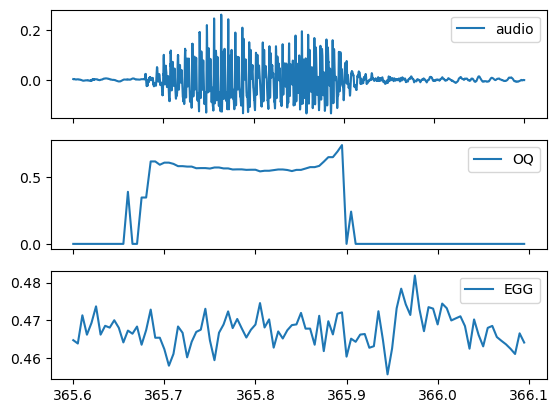

In [58]:
time = [i/fs for i in range(audio.size)] 

start_time = 365.6
end_time = start_time + 0.5

start_sample = int(start_time*fs)
end_sample = int(end_time*fs)

start_frame = int(start_time*frame_rate)
end_frame = int(end_time*frame_rate)


fig = plt.figure()
ax1 =fig.add_subplot(311,)
ax1.plot(time[start_sample:end_sample],audio[start_sample:end_sample],label="audio")
ax1.set_xticklabels([])
ax1.legend()
ax2 =fig.add_subplot(312)
ax2.plot(ftime[start_frame:end_frame],OQ[start_frame:end_frame],label="OQ")
ax2.set_xticklabels([])
ax2.legend()
ax3 =fig.add_subplot(313)
ax3.plot(ftime[start_frame:end_frame],egg[start_frame:end_frame],label="EGG")
ax3.legend()

Audio(audio[start_sample:end_sample],rate=fs)

# 5. Loop

In [30]:
datadir = Path('/Users/ambergalvano/Library/CloudStorage/GoogleDrive-amber_galvano@berkeley.edu/My Drive/research_projects/Lobi/Galvano_Lobi_phonetics/data/EGG+vowels_pt2/full_recordings/Sansan').absolute()
egg_files = dir2df(datadir, fnpat=r'\.wav$')
egg_files

,relpath,fname
0,SH_20230323_EGG1,lob_san_20230323_acg_EGG_SIGNAL_1.wav
1,SH_20230823_143156_EGG1,SH_20230823_143156_EGG1.wav
2,SH_20230823_150052_EGG2,SH_20230823_150052_EGG2.wav
3,SH_20230823_152823_EGG3,SH_20230823_152823_EGG3.wav
4,SH_20230829_111622_EGG4,SH_20230829_111622_EGG4.wav
5,SH_20230829_112135_EGG5,SH_20230829_112135_EGG5.wav
6,SH_20230829_115041_EGG6,SH_20230829_115041_EGG6.wav


In [32]:
dflist = []

for row in egg_files.itertuples():
    print(row.relpath)

    file = Path(datadir, row.relpath, row.fname)
    data, fs = librosa.load(file, sr=16000, mono=False,)
    print(f'sampling rate: {fs}, Number of samples {data.shape[1]}, and channels: {data.shape[0]}')
    
    audio = data[0]
    egg_x = data[1]

    cutoff_freq = 70
    filter_order = 8
    coefs = sp.signal.butter(filter_order, cutoff_freq, fs=fs, btype='highpass', output='sos')
    egg = sp.signal.sosfiltfilt(coefs, egg_x)

    degg = np.gradient(egg)
    
    # scale the filtered egg and degg to (0,1)
    egg = (egg - np.min(egg))/(np.max(egg)-np.min(egg))
    degg = (degg - np.min(degg))/(np.max(degg)-np.min(degg))
    
    # ** thresholding method of calculating closed quotient could use this signal (not used)
    closed = egg > 0.43
    
    # ** hybrid method of OQ calculation
    # get peaks in the degg waveform - the glottal closing instants (gci)
    # minimum spacing between peaks (distance) is 5.5 ms
    degg_peaks = sp.signal.find_peaks(degg,distance=0.0055*fs)
    glottal = np.zeros(degg.size)
    glottal[degg_peaks[0]]=1  # closing times (peaks returns indices of peaks)
    for i in range(egg.size-1):  # opening times (threshold method)
        if egg[i]>0.43 and egg[i+1]<0.43:
            glottal[i] = -1

    window_length = 0.02
    hop_dur = 0.005
    frame_rate = 1/hop_dur
    
    win = int(window_length*fs)  # 15ms windows,
    hop = int(hop_dur*fs)  # 5ms hop
    
    frames = make_frames(glottal,win,hop)   # split the glottal events waveform into frames
    ftime = [i/frame_rate for i in range(frames.shape[0])]  # get times of frames, for plotting
    
    print(f'{frames.shape[0]} frames will be processed')
    
    f0 = np.zeros(frames.shape[0])
    OQ = np.zeros(frames.shape[0])
    
    OQ_data = pd.DataFrame()
    OQ_value = []
    f0_value = []
    glottal_k = []
    time = []
    
    for k in range(frames.shape[0]):
    
        gci = np.argwhere(frames[k] == 1.0)  # glottal closures in the frame
        goi = np.argwhere(frames[k] == -1.0)  # glottal openings
        if (gci.size<2):  # nothing to look at
            continue
        if (goi.size<2):  # nothing to look at
            continue
        
        period = gci[1]-gci[0]  # interval between closures
        f0[k] = 1/(period/fs)
        if goi[0] > gci[0] and goi[0]<gci[1]:  # find an appropriate opening instant
            op = goi[0]
        elif goi[1] > gci[0] and goi[1]<gci[1]:
            op = goi[1]
        else:
            continue
        
        OQ[k] = (gci[1]-op)/period
        
        OQ_value.append(OQ[k])
        time.append(ftime[k])
        glottal_k.append(glottal[k])
    
    OQ_value = [str(x) for x in OQ_value]
    time = [str(x) for x in time]
    glottal_k = [str(x) for x in glottal_k]

    OQ_data["OQ_value"] = pd.DataFrame(OQ_value)
    OQ_data["OQ_time"] = pd.DataFrame(time)
    
    fname_end = str(row.fname).rsplit('/', 1)[-1]
    OQ_data['recording'] = fname_end
    
    dflist.append(OQ_data)

fulldf = pd.concat(dflist, ignore_index=True)
fulldf.head()

SH_20230323_EGG1
sampling rate: 16000, Number of samples 15352459, and channels: 2
191902 frames will be processed


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f0[k] = 1/(period/fs)
/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OQ[k] = (gci[1]-op)/period


SH_20230823_143156_EGG1
sampling rate: 16000, Number of samples 25668800, and channels: 2
320856 frames will be processed


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f0[k] = 1/(period/fs)
/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OQ[k] = (gci[1]-op)/period


SH_20230823_150052_EGG2
sampling rate: 16000, Number of samples 25632000, and channels: 2
320396 frames will be processed


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f0[k] = 1/(period/fs)
/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OQ[k] = (gci[1]-op)/period


SH_20230823_152823_EGG3
sampling rate: 16000, Number of samples 22441600, and channels: 2
280516 frames will be processed


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f0[k] = 1/(period/fs)
/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OQ[k] = (gci[1]-op)/period


SH_20230829_111622_EGG4
sampling rate: 16000, Number of samples 4049600, and channels: 2
50616 frames will be processed


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f0[k] = 1/(period/fs)
/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OQ[k] = (gci[1]-op)/period


SH_20230829_112135_EGG5
sampling rate: 16000, Number of samples 27572800, and channels: 2
344656 frames will be processed


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f0[k] = 1/(period/fs)
/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OQ[k] = (gci[1]-op)/period


SH_20230829_115041_EGG6
sampling rate: 16000, Number of samples 25953600, and channels: 2
324416 frames will be processed


/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f0[k] = 1/(period/fs)
/var/folders/_p/8f1m1pq55m96ch4vpbjsm5zh0000gn/T/ipykernel_34843/3737445297.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  OQ[k] = (gci[1]-op)/period


,OQ_value,OQ_time,recording
0,0.3867924528301887,0.45,lob_san_20230323_acg_EGG_SIGNAL_1.wav
1,0.018691588785046728,0.455,lob_san_20230323_acg_EGG_SIGNAL_1.wav
2,0.8804347826086957,0.46,lob_san_20230323_acg_EGG_SIGNAL_1.wav
3,0.8804347826086957,0.465,lob_san_20230323_acg_EGG_SIGNAL_1.wav
4,0.2037037037037037,0.475,lob_san_20230323_acg_EGG_SIGNAL_1.wav


In [33]:
fulldf['recording'].unique()

array(['lob_san_20230323_acg_EGG_SIGNAL_1.wav',
       'SH_20230823_143156_EGG1.wav', 'SH_20230823_150052_EGG2.wav',
       'SH_20230823_152823_EGG3.wav', 'SH_20230829_111622_EGG4.wav',
       'SH_20230829_112135_EGG5.wav', 'SH_20230829_115041_EGG6.wav'],
      dtype=object)

In [12]:
#fulldf.to_csv('./Sansan_OQ_data_12-20-24.csv')